In [1]:
import pyspark
from pyspark.sql import SQLContext
import pyspark.sql.functions as func
from pyspark.sql.functions import col
from pyspark.sql.functions import sum

In [2]:
sc = pyspark.SparkContext(appName="Tags")

In [3]:
sqlContext = SQLContext(sc)

In [4]:
df = sqlContext.read.json("./data/results/Tags/part-00000")

In [25]:
tag_dict = {
    "mysql.*": "mysql",
    "innodb": "mysql",
    "myisam": "mysql",
    "sql-server.*": "sql-server",
    "ssms": "sql-server",
    "ssis": "sql-server",
    "t-sql": "sql-server",
    "postgresql.*": "postgres",
    "oracle.*": "oracle",
    "document-oriented":"mongodb",
    "phpmyadmin": "postgres",
    "plsql": "oracle",
    "plpgsql": "postgres",
    "sqlplus": "oracle",
    "rman": "oracle",
    "pgadmin": "postgres",
    "windows-server.*":"sql-server",
    "pg-dump": "postgres",
    "psql": "postgres",
    "postgis": "postgres",
    "nosql": "mongodb",
    "mongo.*": "mongodb"
        }
tag_list=list(tag_dict.values())
tag_list

['mysql',
 'postgres',
 'sql-server',
 'oracle',
 'postgres',
 'postgres',
 'postgres',
 'sql-server',
 'mongodb',
 'sql-server',
 'mysql',
 'oracle',
 'postgres',
 'oracle',
 'mysql',
 'postgres',
 'mongodb',
 'sql-server',
 'oracle',
 'sql-server',
 'mongodb',
 'postgres']

In [19]:
def standardize_tags(col):
    for i in tag_dict:
        col=func.regexp_replace(col, i, tag_dict[i])
    return col

In [26]:
new_df=df.select("TagName", "Count") \
    .withColumn('TagName_std', standardize_tags('TagName')) \
    .withColumn("Count", df["Count"].cast('int')) \
    .sort(col("Count").desc())
new_df.show(200)

+--------------------+-----+--------------------+
|             TagName|Count|         TagName_std|
+--------------------+-----+--------------------+
|          sql-server|17351|          sql-server|
|               mysql|13032|               mysql|
|                 sql| 7966|                 sql|
|          postgresql| 6160|            postgres|
|              oracle| 4720|              oracle|
|     database-design| 3517|     database-design|
|     sql-server-2008| 3433|          sql-server|
|  sql-server-2008-r2| 3264|          sql-server|
|     sql-server-2012| 3199|          sql-server|
|         performance| 2066|         perfooracle|
|         replication| 2049|         replication|
|               index| 1708|               index|
|               t-sql| 1552|          sql-server|
|              innodb| 1492|               mysql|
|     sql-server-2014| 1467|          sql-server|
|   query-performance| 1430|   query-perfooracle|
|              backup| 1345|              backup|


In [27]:
df_filtered=new_df \
.sort(col("Count").desc()) \
.filter(new_df.TagName_std.isin(tag_list)==True)
df_filtered.show(300)

+--------------------+-----+-----------+
|             TagName|Count|TagName_std|
+--------------------+-----+-----------+
|          sql-server|17351| sql-server|
|               mysql|13032|      mysql|
|          postgresql| 6160|   postgres|
|              oracle| 4720|     oracle|
|     sql-server-2008| 3433| sql-server|
|  sql-server-2008-r2| 3264| sql-server|
|     sql-server-2012| 3199| sql-server|
|               t-sql| 1552| sql-server|
|              innodb| 1492|      mysql|
|     sql-server-2014| 1467| sql-server|
|     sql-server-2005| 1284| sql-server|
|             mongodb| 1139|    mongodb|
|       oracle-11g-r2| 1009|     oracle|
|           mysql-5.5|  994|      mysql|
|                ssis|  665| sql-server|
|           mysql-5.6|  627|      mysql|
|                ssms|  607| sql-server|
|      postgresql-9.3|  512|   postgres|
|          oracle-11g|  491|     oracle|
|           mysqldump|  487|      mysql|
|     sql-server-2016|  394| sql-server|
|      postgresq

In [ ]:
types = [f.dataType for f in df_filtered.schema.fields]
types

In [28]:
df_aggr=df_filtered.groupBy("TagName_std") \
.agg(func.sum("Count")).sort(col("sum(Count)").desc())
df_aggr.show(10)
# df_aggr.show(100)

+-----------+----------+
|TagName_std|sum(Count)|
+-----------+----------+
| sql-server|     34333|
|      mysql|     18271|
|   postgres|      9032|
|     oracle|      8087|
|    mongodb|      1576|
+-----------+----------+



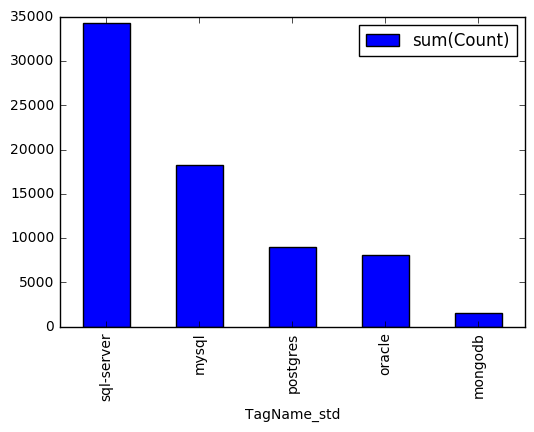

In [29]:
%matplotlib inline
pdf=df_aggr.toPandas().plot(x="TagName_std", y="sum(Count)", kind="bar")